# Regression and Other Stories: Simple regression

In [1]:
import arviz as az
from bambi import Model, Prior
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


In [2]:
# seed for reproducibility
rng = np.random.default_rng(seed=42)

In [3]:
az.style.use('arviz-grayscale')

### Fitting a regression using a data frame in python

#### Simulate fake data

In [4]:
# R is one indexed
x = np.arange(1, 21)
n = len(x)
a = 0.2
b = 0.3
sigma = 0.5
y = a + b * x + sigma * stats.norm().rvs(n, random_state=rng)


In [5]:
fake = pd.DataFrame({"x": x, "y": y})


#### Linear regression model

In [6]:
model = Model("y ~ x", data=fake)
results = model.fit()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [7]:
func_dict = {
    "Median": np.median,
    "MAD_SD": stats.median_abs_deviation,
}

coefs = az.summary(results, stat_funcs=func_dict, extend=False, round_to=2)
coefs


,Median,MAD_SD
Intercept,0.05,0.15
x,0.31,0.01
y_sigma,0.46,0.05


#### Plot for book

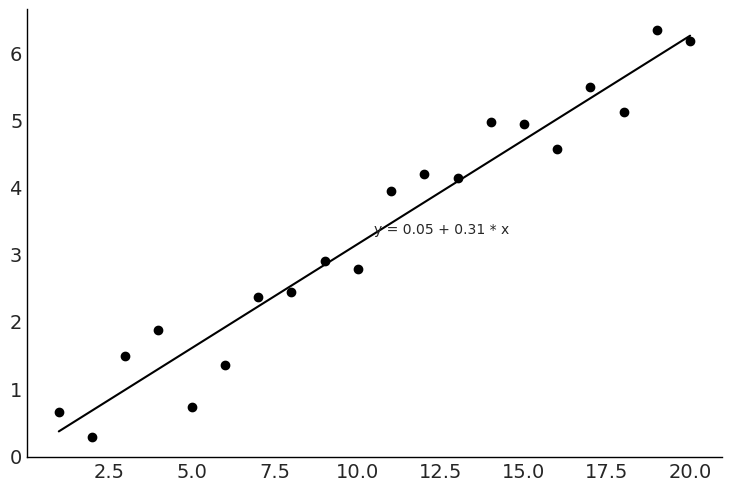

In [8]:
a_hat = coefs.loc["Intercept", "Median"]
b_hat = coefs.loc["x", "Median"]

fig, ax = plt.subplots()
ax.plot(x, a_hat + b_hat * x)
ax.scatter(x, y)

x_bar = x.mean()
ax.text(
    x_bar,
    a_hat + b_hat * x_bar,
    f"y = {np.round(a_hat, 2)} + {np.round(b_hat, 2)} * x",
);


### Formulating comparisons as regression models

#### SImulate fake data

In [9]:
n_0 = 200
y_0 = stats.norm(2, 5).rvs(n_0, random_state=rng)
fake_0 = pd.DataFrame(dict(y_0=y_0))
print(y_0.round(1))

[ 1.1 -1.4  8.1  1.2 -0.1  0.2  4.7  3.8  4.1  4.2 12.7 -0.  -0.6 -2.1
  5.1  7.6  1.4 -2.2 -2.1  5.3  5.7  4.7 -1.3  3.2  2.6  3.1  6.4  3.1
  5.4  2.3  3.4  5.2 -5.3  0.4 -0.4 -1.2  0.6  9.5 -2.3  6.8 -6.4  0.3
  2.8  4.9  5.6  6.   0.3 -0.3  6.3  1.  -4.4 -3.7 -2.6  4.5  2.7  5.5
 -0.1  2.8  5.1  0.5  4.3 -1.3  0.2  0.1 -4.   4.4 -0.3  2.1  4.4  4.2
  5.3  1.5 -0.1  1.6 -6.4 -5.2 -4.6 -3.   4.  -2.5  0.1  8.5  0.2  5.7
 -2.7  1.  -2.8  0.3  6.2 -6.6  4.2  3.2 -1.  -5.2  2.4 -0.6  3.2  2.1
 10.   0.8 -3.1  2.9  3.1  8.8  6.2  3.8  9.3 -3.9 -1.2 -2.6  0.1 -4.9
  5.2  0.9 -5.4 -3.1  3.6  6.2 12.  16.6  4.1 -2.9 -8.7  3.3 -2.1 -0.1
 -1.1  1.3  7.3  2.8  1.2 -3.2 -6.4 -0.4  1.7 10.8  2.7  6.9 -0.5 -3.9
 -2.8 -1.6 12.6 -2.1  6.2 -2.5  6.7  3.9  1.2  1.8 -1.3  4.2 -0.3 -4.1
 -4.4  2.9  9.9  2.8  1.4  3.4  8.5  3.1 -0.1  7.5  4.1  9.7  2.9 -4.1
 -4.8 10.3 10.6  1.1  0.1  9.3 -3.5 -2.5  5.2  0.   2.   1.2  3.7  9.
  2.5  5.2 -8.3  1.8 -2.2 -4.1 -2.4  0.3  6.6 -4.6  2.2 -0.4  0.4  7.
  4.7  8

In [10]:
np.round(y_0.mean(), 2)


1.81

In [11]:
np.round(y_0.std() / np.sqrt(n_0), 2)


0.31

#### Estimating the mean is the same as regressing on a constant term

In [12]:
priors = {"y_0_sigma": Prior("Flat"), "Intercept": Prior("Flat")}

model = Model("y_0 ~ 1", fake_0, priors=priors)
results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_0_sigma, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [13]:
func_dict = {
    "Median": np.median,
    "MAD_SD": stats.median_abs_deviation,
}

coefs = az.summary(results, stat_funcs=func_dict, extend=False)
coefs


,Median,MAD_SD
Intercept,1.818,0.214
y_0_sigma,4.435,0.144


In [14]:
n_1 = 300
y_1 = stats.norm(8, 5).rvs(n_1, random_state=rng)
diff = y_1.mean() - y_0.mean()
se_0 = y_0.std() / np.sqrt(n_0)
se_1 = y_1.std() / np.sqrt(n_1)
se = np.sqrt(se_0**2 + se_1**2)
print(diff)

6.231753207569243


In [15]:
print(se)

0.4313163125477724


#### Estimating a difference is the same as regressing on an indicator variable

In [16]:
n = n_0 + n_1
y = np.concatenate((y_0, y_1))
x = np.concatenate((np.zeros(n_0), np.ones(n_1)))
fake = pd.DataFrame(dict(y=y, x=x))

In [17]:
priors = {"y_0_sigma": Prior("Flat"), "Intercept": Prior("Flat")}
model = Model("y ~ x", fake)
results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [18]:
func_dict = {
    "Median": np.median,
    "MAD_SD": stats.median_abs_deviation,
}

coefs = az.summary(results, stat_funcs=func_dict, extend=False)
coefs


,Median,MAD_SD
Intercept,1.807,0.244
x,6.235,0.302
y_sigma,4.884,0.106


### Plot for the book

In [19]:
a_hat = coefs.loc["Intercept", "Median"]
b_hat = coefs.loc["x", "Median"]
x_bar = x.mean()
y0 = y[x == 0].mean().round(2)
y1 = y[x == 1].mean().round(2)

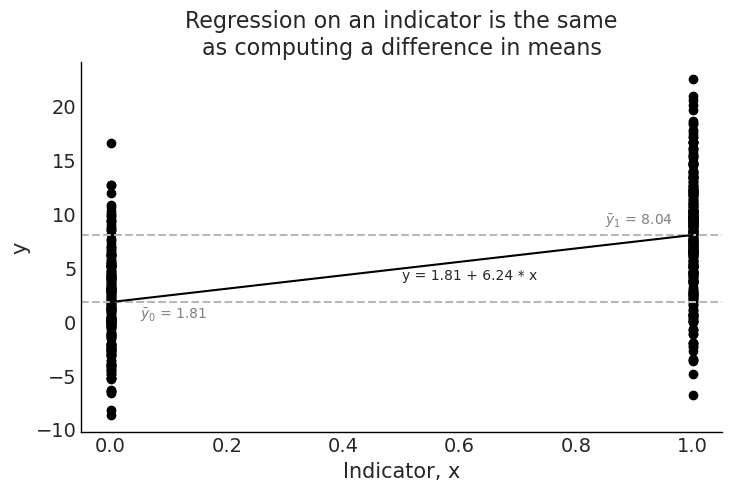

In [20]:
fig, ax = plt.subplots()

# plot the points
ax.scatter(x, y)

# plot y0 and y1 mean
ax.axhline(y=y0, color="C3", linestyle="dashed")
ax.axhline(y=y1, color="C3", linestyle="dashed")

# plot the regression line
ax.plot(x, a_hat + b_hat * x)


# Add texts for each line
ax.text(
    0.5,
    -1 + a_hat + 0.5 * b_hat,
    f"y = {np.round(a_hat, 2)} + {np.round(b_hat, 2)} * x",
)
ax.text(0.05, -1.5 + y[x == 0].mean(), f"$\\bar{{y}}_0$ = {y0}", color="gray")
ax.text(0.85, 1 + y[x == 1].mean(), f"$\\bar{{y}}_1$ = {y1}", color="gray")

# Add labels
ax.set(
    xlabel="Indicator, x",
    ylabel="y",
    title="Regression on an indicator is the same\nas computing a difference in means",
)
